<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/LHCb_no_root_ipynb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File handaling**<br>
Install all the libraries needed for the code

In [1]:
#try not to use extended function, but just normal ones and see what happen
#when you do it, for the plotting and in the for ..... frac in ..... (model.get_params())
#try to use the NLL fitting and increase the binning
!pip install uproot awkward lz4 xxhash
!pip install zfit
!pip install mplhep


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import uproot
f=uproot.open ("/content/drive/MyDrive/B2HHH_MagnetDown.root")
f.keys()

['DecayTree;1']

In [3]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt


In [4]:
tree=f["DecayTree"].arrays(library="np")

**Defining classes and useful functions**<br>
In this cell, I defined a class and some functions to avoid repetitions in the code, in particular
<ul>
<li> The class Daughter, which creates a daughter particle given the tree and the number (1,2, or 3), retrieving information about its momentum on the three components, the probabilities of being a kaon or a pion, calculating its total momentum. In addition, it has also a method to calculate the total energy of the particle. Although this may be an unusual approach, in my opinion, it simplifies the readability of the code and the accessibility of the information 
<li> A function to create three daughter particles given the tree
<li> A function to calculate the total momentum of the mother and a function to calculate its mass
<li> a function to plot simple histogram(s)
<li> A function to fit and plot the fitted the model
<li> A function to calculate the asymmetry and one for its uncertainty


</ul>


In [5]:
#defining useful classes and functions
class Daughter:
  def __init__(self, tree, number):
    self.PX=tree["H{}_PX".format(number)]
    self.PY=tree["H{}_PY".format(number)]
    self.PZ=tree["H{}_PZ".format(number)]
    self.PTOT=sqrt(square(self.PX)+square(self.PY)+square(self.PZ))#total momentum of the daughter particle
    self.ProbK=tree["H{}_ProbK".format(number)]
    self.ProbPi=tree["H{}_ProbPi".format(number)]
    
  def getTotalEnergy(self, mass):
    return  sqrt(square(self.PTOT)+mass**2)#total energy of the particle

def getDaughterParticles(tree):
  daughters=[]
  for i in range(1,4):
    daughters.append(Daughter(tree,i))
  return daughters


def totalMomentumMother(H1,H2,H3):
  return sqrt(square(H1.PX+H2.PX+H3.PX)+square(H1.PY+H2.PY+H3.PY)+square(H1.PZ+H2.PZ+H3.PZ))

def massMother(H1,H2,H3,mass):
  return sqrt(square(H1.getTotalEnergy(mass)+H2.getTotalEnergy(mass)+H3.getTotalEnergy(mass))-square(totalMomentumMother(H1,H2,H3)))

def plotHists(data,bins,range,labels=None,title=None,xlabel=None,ylabel=None,grid=False,loc="upper right"):
  for dat in data:
    plt.hist(dat,bins,range,histtype='step');
  if labels: plt.legend(labels,loc=loc); 
  if title : plt.title(title); 
  if xlabel: plt.xlabel(xlabel);  
  if ylabel: plt.ylabel(ylabel);  
  if grid: plt.grid();  
  plt.show()
  return

def getModel(model,data,bins=300,title=None): 
  #binning
  binning = zfit.binned.RegularBinning(bins, 5200,5800, name="mass")
  mass_binned = zfit.Space("mass", binning=binning)
  data_binned = data.to_binned(mass_binned)
  model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, mass_binned)
  #fitting
  nll = zfit.loss.ExtendedBinnedChi2(model_binned, data_binned)
  minimizer = zfit.minimize.Minuit()
  result = minimizer.minimize(nll)
  print(result)
  #chi2
  chi2=nll.value().numpy()
  dof=bins-len(model.get_params())
  #plotting, taken and modified from https://indico.cern.ch/event/882824/contributions/3932489/:
  lower, upper = data.data_range.limit1d
  counts, bin_edges = histogram(data.to_pandas(), bins=bins)
  plt.figure(figsize=(10,6))
  mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True, label="Data", color="black")
  binwidth = diff(bin_edges)[0]
  x = linspace(lower, upper, num=1000)
  y = model.ext_pdf(x) * binwidth
  plt.plot(x,y,label="model",color="blue")
  for mod, lab, col  in zip(model.get_models(),["signal","background"],["red","green"]):
    y_m=mod.ext_pdf(x) * binwidth
    plt.plot(x,y_m,label=lab,color=col,ls="--")
  plt.legend(loc="upper right")
  if title:
    plt.title(title)
  plt.show()
  return result.params,chi2/dof



def asymmetry(Nplus, Nminus):
  return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
  return sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))






In [6]:
#creating the istances for the three daughter particles
H1,H2,H3=getDaughterParticles(tree)


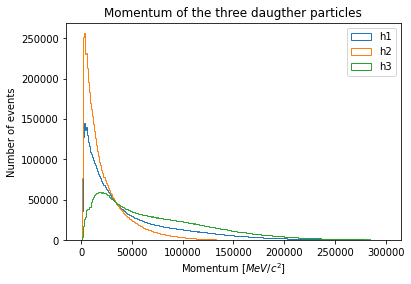

In [7]:
#plotting the hystogram

bins=300
range_hist=(0,300000)

plotHists([H1.PTOT,H2.PTOT,H3.PTOT],bins,range_hist,title="Momentum of the three daugther particles",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events',labels=['h1','h2','h3'])



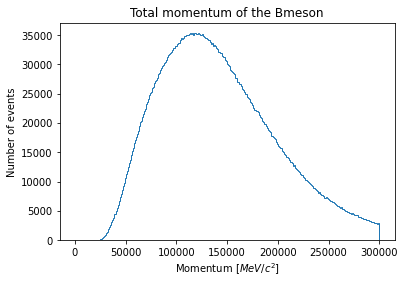

In [8]:
#Calculating the total momentum of the mother 
mother_ptot=totalMomentumMother(H1,H2,H3)


plotHists([mother_ptot],bins,range_hist,title="Total momentum of the Bmeson",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')

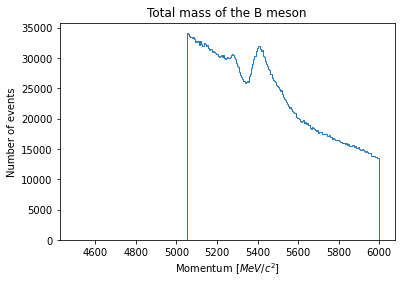

In [9]:
#total mass of the mother
massK=493.677
mass_mother=massMother(H1,H2,H3,massK)

range_hist=(4500,6000)

plotHists([mass_mother],bins,range_hist,title="Total mass of the B meson",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')
#Does this match what we would expect from theory?

According to Wikipedia (https://en.wikipedia.org/wiki/B_meson), the mass for B meson is $5279.34\  MeV/c^2$. The histogram has three peaks: 
<ul>
<li> The highest around $5000\  MeV/c^2$
<li> A second one between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the theoretical mass of B mesons)
<li> A third one around $5400\  MeV/c^2$
</ul>
Considering that no filter has been applied yet and, therefore, there are also data about particles that are not B meson, the results seem reasonable.

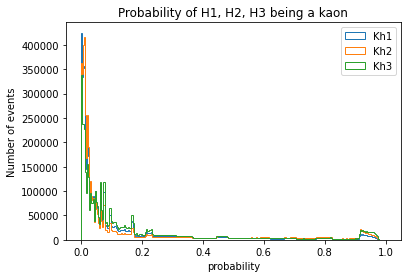

In [10]:
#Make plots of H1/H2/H3 _ProbK on one plot

range_hist=(0,1)

plotHists([H1.ProbK,H2.ProbK,H3.ProbK],bins,range_hist,title="Probability of H1, H2, H3 being a kaon",xlabel='probability'
,ylabel='Number of events',labels=['Kh1','Kh2','Kh3'])


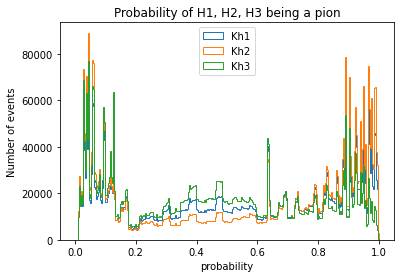

In [11]:
#Make plots of H1/H2/H3 _ProbPi on one plot
range_hist=(0,1)

plotHists([H1.ProbPi,H2.ProbPi,H3.ProbPi],bins,range_hist,title="Probability of H1, H2, H3 being a pion",xlabel='probability'
,ylabel='Number of events',labels=['Kh1','Kh2','Kh3'],loc="upper center")


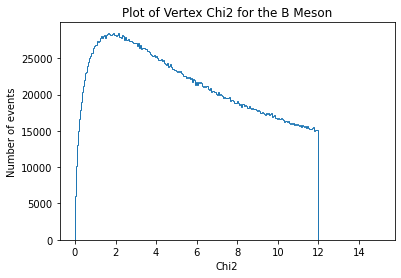

In [12]:
#make a plot of the B_VertexChi2
range_hist=(0,15)

plotHists([tree["B_VertexChi2"]],bins,range_hist,title="Plot of Vertex Chi2 for the B Meson",xlabel='Chi2'
,ylabel='Number of events')


Based on the previous plots, it was decided to keep the data relative to those particles whose probability to be a Kion is more than 50%, that are not muon and whose probability to be a pion is less tha 0.15%

In [13]:
#Making the selction
selection="(H1_ProbK>0.5) & (H2_ProbK>0.5) & (H3_ProbK>0.5) & (H1_ProbPi<0.15) & (H1_isMuon==0) & (H2_isMuon==0) &(H3_isMuon==0)& (H2_ProbPi<0.15) & (H3_ProbPi<0.15)"
cutTree=f["DecayTree"].arrays(library="np",cut=selection)



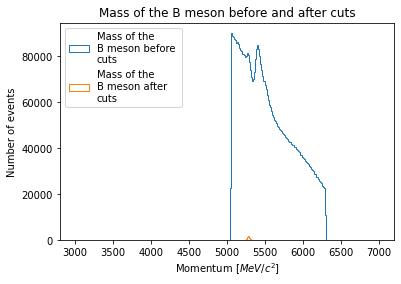

In [14]:
H1_cut,H2_cut,H3_cut=getDaughterParticles(cutTree)

range_hist=(3000,7000)
mass_mother_cut=massMother(H1_cut,H2_cut,H3_cut,massK)

plotHists([mass_mother,mass_mother_cut],bins,range_hist,title="Mass of the B meson before and after cuts",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events',labels=["Mass of the \nB meson before \ncuts","Mass of the \nB meson after \ncuts"],loc="upper left")



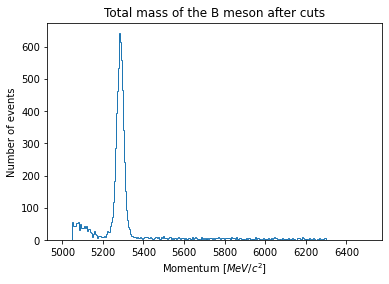

In [15]:
#mother cut alone

range_hist=(5000,6500)

plotHists([mass_mother_cut],bins,range_hist,title="Total mass of the B meson after cuts",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')


#What do you notice about your histogram now?


The histogram is now way narrower, with the peak between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the mass of the B mesons). However, the number of events is greatly reduced. 

In [16]:
import zfit

import mplhep

/usr/local/lib/python3.8/dist-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [17]:
mass=zfit.Space("mass",limits=(5200,5800))
data = zfit.Data.from_numpy(obs=mass, array=mass_mother_cut)#selecting the data in that range

#signal
gauss_mean=zfit.Parameter("mean",5300,5200,5900)
gauss_width=zfit.Parameter("sd",40,0,7000)
gauss_norm=zfit.Parameter("signal yield",len(data.to_pandas())/30, 0, len(data.to_pandas())*3)


#background
lam=zfit.Parameter("lambda",-0.02, -2, +2)
exp_norm=zfit.Parameter("background yield",len(data.to_pandas())/30, 0, len(data.to_pandas())*3)


/usr/local/lib/python3.8/dist-packages/zfit/_loss/binnedloss.py:511: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['chi2_counts_small'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
Some values in                  ┌───────────────────────────────────────────────────────────┐
[5200, 5202) 4   │▉                                                          │
[5202, 5204) 5   │█▏                                                         │
[5204, 5206) 4   │▉                                                          │
[5206, 5208) 5   │█▏                                                         │
[5208, 5210) 4   │▉                                                          │
[5210, 5212) 5   │█▏                                                         │
[5212, 5214) 4   │▉                                                          │
[5214, 5216) 4   │

FitResult of
<ExtendedBinnedChi2 model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f831b54b460>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f83167a4460>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00022 │ 6.679929    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                value  (rounded)    at limit
----------------  ------------------  ----------
signal yield                 5200.72       False
background yield             782.514       False
mean                         5284.06       False
sd                           17.5087       False
lambda                   -0.00167675       False


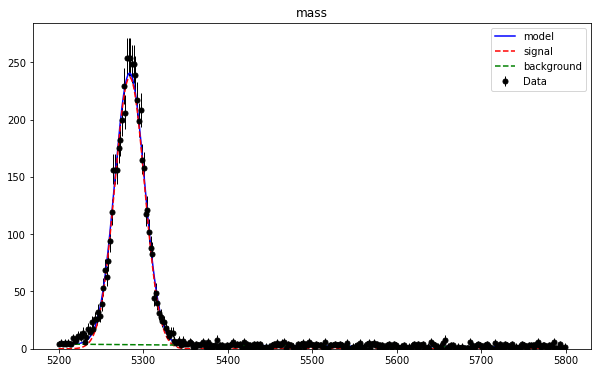

In [18]:
#creating the model
signal=zfit.pdf.Gauss(obs=mass, mu=gauss_mean, sigma=gauss_width).create_extended(gauss_norm)
bckg=zfit.pdf.Exponential(lam, obs=mass).create_extended(exp_norm)

model=zfit.pdf.SumPDF([signal,bckg])

#getting the model
result,chi2=getModel(model,data,title="mass")



In [19]:
print("signal yield: ",result[gauss_norm]["value"],"\nbackground yield: ",result[exp_norm]["value"],"\nchi2:",chi2)

signal yield:  5200.718388943243 
background yield:  782.5142168372419 
chi2: 0.022643837657165843


**Counting**

In [20]:
totalCharge= "H1_Charge+H2_Charge+H3_Charge"
#filtering by charge
B_minus=f["DecayTree"].arrays(cut="({}==-1)&{}".format(totalCharge,selection), library="np")#with numpy gives some errors
B_plus=f["DecayTree"].arrays(cut="({}==1)&{}".format(totalCharge,selection), library="np")


FitResult of
<ExtendedBinnedChi2 model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f8402c21370>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f8402c21a00>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.1e-06 │ 210.8625    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                value  (rounded)    at limit
----------------  ------------------  ----------
signal yield                 2410.31       False
background yield             494.163       False
mean                         5285.05       False
sd                           17.3603       False
lambda                   -0.00118202       False


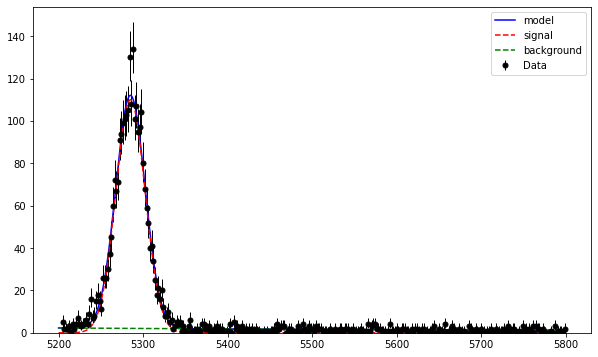

In [31]:
#Model B_minus
H1_Bminus,H2_Bminus,H3_Bminus=getDaughterParticles(B_minus)
mass_mother_Bminus=massMother(H1_Bminus,H2_Bminus,H3_Bminus,massK)

data_B_minus=zfit.Data.from_numpy(obs=mass, array=mass_mother_Bminus)#selecting the data in that range

params,chi_2_minus=getModel(model,data_B_minus)
N_minus=params[gauss_norm]["value"]

In [33]:
print("N minus: ",N_minus,"\nchi2 minus:",chi_2_minus)

N minus:  2410.3075728171875 
chi2 minus: 0.714788137727241


FitResult of
<ExtendedBinnedChi2 model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f8438b86670>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f8402c738b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.8e-05 │ 217.0746    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                value  (rounded)    at limit
----------------  ------------------  ----------
signal yield                 2723.62       False
background yield             457.124       False
mean                         5283.14       False
sd                           16.9185       False
lambda                  -0.000927114       False


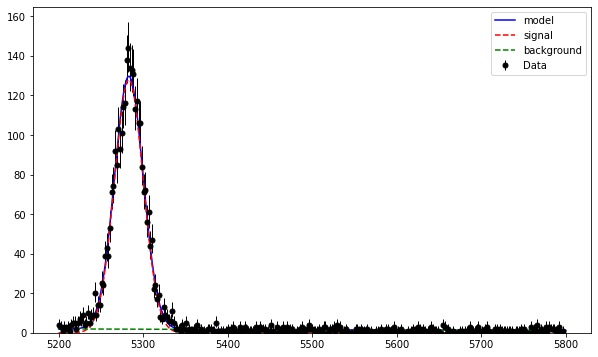

In [26]:
#Model B_plus
H1_Bplus,H2_Bplus,H3_Bplus=getDaughterParticles(B_plus)
mass_mother_Bplus=massMother(H1_Bplus,H2_Bplus,H3_Bplus,massK)

data_B_plus=zfit.Data.from_numpy(obs=mass, array=mass_mother_Bplus)

params,chi_2_plus=getModel(model,data_B_plus)
N_plus=params[gauss_norm]["value"]


In [27]:
print("N plus: ",N_plus,"\nchi2 plus:",chi_2_plus)

N minus:  2723.6243242881483 
chi2 minus: 0.7358462024270045


In [28]:
print("asymmetry: ",asymmetry(Nminus=N_minus,Nplus=N_plus),"\nuncertainty:",deviation(Nminus=N_minus,Nplus=N_plus))

asymmetry:  -0.06098319494413166 
uncertainty: 0.013930175486985176


The results shows indeed an asimmetry between the B+ meson and B-. This prevalence of the matter over anti-matter is why we (and the entire universe) exist. 